# Chapter03 word2vec

---

#### カウントベースの手法の問題点と推論ベースの違い

- 計算コストが$O(N^3)$
- なのでコーパス内の語彙数が多ければ多いほど膨大な計算リソースや時間が要求される
  - これはコーパス全体の統計データを基にするバッチ学習であるから
  - これに対し推論ベースではNN等を用いる為ミニバッチ学習を行う

---

#### 推論ベース手法

- 周囲の単語(コンテキスト)が与えられた際に間には何の単語が入るかを推測する
  - ex) "you ??? goodbye ... " においてyou, goodbyeが与えられた際に???には何が入るか？
- コンテキストを入力としたNNモデルを用いて出現しうるであろう各単語の出現確率を出力する
- NNで単語を処理するには単語をone-hot表現(one-hotベクトル)へ変換する必要がある
  - ベクトルで表現ができればNNを構成する様々な層によって処理することができる

### 前準備(各種ライブラリのimport)

In [1]:
# 基本のライブラリ
import numpy as np

# 以下のは過去のチャプターで実装している
# 再記述が手間なので別のpyファイルから読み込む
from common.layers import MatMul, SoftmaxWithLoss
from common.util import preprocess
from common.optimizer import Adam

# 以下のは1章で作成したNNの学習用のコード
# 学習~評価までを行う
from common.trainer import Trainer

## シンプルなword2vec

- word2vecとは本来はプログラムやツール類を指す
  - 文脈によってはNNのモデルを指す場合も見受けられつつある
  - 実際にword2vecで使用されているモデルはCBOWモデルとskip-gramモデルの2つ

---

### CBOW(continuous bag-of-words)モデル

- コンテキスト(周囲の単語)からターゲット(中央の単語)を推測することを目的としたNN
- モデルへの入力はコンテキスト
  - ['you', 'goodbye']のような単語リストでコンテキストは表される
- 入力層はコンテキストとして扱う単語の数になる
  - 今回はターゲットに隣接するコンテキストを対象とするので、入力層は2
- 入力層→中間層への変換は同じ全結合層で行われる
  - 中間層では各入力層の全結合による変換後の値が平均されたものになる
    - 本例で言えば中間層のニューロンは$\frac{1}{2}(h_1+h_2)$
- 中間層→出力層への変換は別の全結合層で行われる
  - 出力層のニューロンは各単語のスコア = ニューロンは各単語に対応している
    - これにSoftmax関数を適用すれば確率を求められる

### CBOWの推論処理(スコアを求める処理)

In [2]:
# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0 ,0]])
c1 = np.array([[0, 0, 1, 0, 0, 0 ,0]])

# 重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# レイヤ生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 順伝播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[ 0.5574752  -0.46533007  0.45890611 -0.18713521 -0.35393294 -1.47822371
   0.31384984]]


### CBOWモデルの学習

- word2vecの学習を行うにあたり、まず学習データを準備する
  - 文章の例は過去の回と同じ

In [3]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


- 文章のコーパスからコンテキストとターゲットを作成する
  - corpus: [0 1 2 3 4 1 5 6] からコンテキスト, ターゲットを作成しようとする場合以下のように表現される(ウィンドウサイズは1)
    - contexts: [[0 2] [1 3] [2 4] ... [1 6]]
    - target: [1 2 3 ... 5]

In [4]:
# コンテキストとターゲットを作成する関数
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t==0: continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)

In [5]:
# 確認
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


- コンテキストとターゲットの各要素が単語ID
  - よって、これをone-hot表現に変換する

In [6]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [7]:
# one-hot表現の確認
vocab_size = len(word_to_id)
target_one_hot = convert_one_hot(target, vocab_size)
contexts_one_hot = convert_one_hot(contexts, vocab_size)
print(target_one_hot)
print("-"*50)
print(contexts_one_hot)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


### CBOWモデルの実装

In [10]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # レイヤ生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 全ての重みと購買をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

#### 学習コード部分の実装

In [12]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts_one_hot, target_one_hot, max_epoch, batch_size)

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 285 |  iter 1 / 2 | time 0[s] | loss 1.19
| epoch 286 |  iter 1 / 2 | time 0[s] | loss 1.09
| epoch 287 |  iter 1 / 2 | time 0[s] | loss 1.07
| epoch 288 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 289 |  iter 1 / 2 | time 0[s] | loss 1.28
| epoch 290 |  iter 1 / 2 | time 0[s] | loss 0.90
| epoch 291 |  iter 1 / 2 | time 0[s] | loss 1.16
| epoch 292 |  iter 1 / 2 | time 0[s] | loss 1.17
| epoch 293 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 294 |  iter 1 / 2 | time 0[s] | loss 1.09
| epoch 295 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 296 |  iter 1 / 2 | time 0[s] | loss 1.16
| epoch 297 |  iter 1 / 2 | time 0[s] | loss 0.98
| epoch 298 |  iter 1 / 2 | time 0[s] | loss 1.09
| epoch 299 |  iter 1 / 2 | time 0[s] | loss 1.05
| epoch 300 |  iter 1 / 2 | time 0[s] | loss 1.16
| epoch 301 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 302 |  iter 1 / 2 | time 0[s] | loss 1.07
| epoch 303 |  iter 1 / 2 | time 0[s] | loss 1.05
| epoch 304 |  iter 1 / 2 | time 0[s] | loss 1.08


| epoch 555 |  iter 1 / 2 | time 0[s] | loss 1.04
| epoch 556 |  iter 1 / 2 | time 0[s] | loss 0.93
| epoch 557 |  iter 1 / 2 | time 0[s] | loss 0.95
| epoch 558 |  iter 1 / 2 | time 0[s] | loss 1.02
| epoch 559 |  iter 1 / 2 | time 0[s] | loss 0.80
| epoch 560 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 561 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 562 |  iter 1 / 2 | time 0[s] | loss 0.93
| epoch 563 |  iter 1 / 2 | time 0[s] | loss 1.04
| epoch 564 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 565 |  iter 1 / 2 | time 0[s] | loss 0.91
| epoch 566 |  iter 1 / 2 | time 0[s] | loss 0.84
| epoch 567 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 568 |  iter 1 / 2 | time 0[s] | loss 0.89
| epoch 569 |  iter 1 / 2 | time 0[s] | loss 0.95
| epoch 570 |  iter 1 / 2 | time 0[s] | loss 0.93
| epoch 571 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 572 |  iter 1 / 2 | time 0[s] | loss 1.04
| epoch 573 |  iter 1 / 2 | time 0[s] | loss 0.93
| epoch 574 |  iter 1 / 2 | time 0[s] | loss 0.81


| epoch 855 |  iter 1 / 2 | time 0[s] | loss 0.75
| epoch 856 |  iter 1 / 2 | time 0[s] | loss 0.98
| epoch 857 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 858 |  iter 1 / 2 | time 0[s] | loss 0.89
| epoch 859 |  iter 1 / 2 | time 0[s] | loss 0.87
| epoch 860 |  iter 1 / 2 | time 0[s] | loss 0.97
| epoch 861 |  iter 1 / 2 | time 0[s] | loss 0.76
| epoch 862 |  iter 1 / 2 | time 0[s] | loss 0.86
| epoch 863 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 864 |  iter 1 / 2 | time 0[s] | loss 1.11
| epoch 865 |  iter 1 / 2 | time 0[s] | loss 0.89
| epoch 866 |  iter 1 / 2 | time 0[s] | loss 0.72
| epoch 867 |  iter 1 / 2 | time 0[s] | loss 0.86
| epoch 868 |  iter 1 / 2 | time 0[s] | loss 0.76
| epoch 869 |  iter 1 / 2 | time 0[s] | loss 0.98
| epoch 870 |  iter 1 / 2 | time 0[s] | loss 0.86
| epoch 871 |  iter 1 / 2 | time 0[s] | loss 0.84
| epoch 872 |  iter 1 / 2 | time 0[s] | loss 0.91
| epoch 873 |  iter 1 / 2 | time 0[s] | loss 0.84
| epoch 874 |  iter 1 / 2 | time 0[s] | loss 0.97


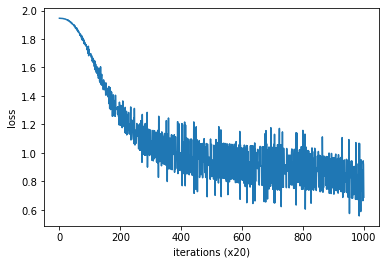

you [-1.1343108  1.1568544 -1.130011   1.1502621  1.2918689]
say [ 1.0615331 -1.0909281  1.2123411 -1.2486699 -1.199011 ]
goodbye [-0.8863822   0.853787   -0.82336384  0.744397    0.5589087 ]
and [ 1.4691869  -1.4988296   0.79566914 -0.77935165 -1.1064413 ]
i [-0.85215753  0.8378915  -0.79839194  0.72768235  0.56784034]
hello [-1.125761   1.1576835 -1.1331197  1.1625919  1.3161727]
. [-0.10630968  0.13622808  1.3213192  -1.3572079  -0.9353679 ]


In [16]:
# 学習の経過表示
trainer.plot()

# 単語の分散表現を確認
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

### word2vecに関する補足

- 確率を以下のように表す
  - $P(A,B)$: 同時確率(A, Bが同時に起こる確率)
  - $P(A|B)$: 事後確率(Bを与えた時にAが起こる確率)

- 上記より, $W_1, W_2 ,..., W_{t-1}, W_{t}, W_{t+1},..., W_{T-1}, W_T$の単語列で示されるコーパスにおいてt番目の単語に対するウィンドウサイズ1のコンテキストは以下となる
  - $P(w_t|w_{t-1},w_{t+1})$
 
- 損失関数は交差エントロピー誤差と上記式より, 以下のようになる
  - $L = -logP(w_t|w_{t-1},w_{t+1})$
  - これを負の対数尤度という
  - 上記の損失関数はひとつのサンプルデータに対するものであるため, コーパス全体に拡張すると以下のように書ける
    - $L = -\dfrac{1}{T}\sum_{t=1}^TlogP(w_t|w_{t-1},w_{t+1})$

---

### skip-gramモデル

- 中央の単語(ターゲット)から周囲の複数ある単語(コンテキスト)を推測する
  - 入力層は1つ, 出力層がコンテキストの数だけ存在する
  - イメージ的にはCBOWとは逆な求め方をする

- その為、skip-gramは以下の式をモデル化することになる
  - $P(w_{t-1},w_{t+1}|w_t)$
  
- ここでskip-gramモデルではコンテキストの単語の間に関連性が無いと仮定し以下のように分解する
  - $P(w_{t-1},w_{t+1}|w_t) = P(w_{t-1}|w_t)P(w_{t+1}|w_t)$
  - 交差エントロピー誤差を適用することで損失関数を導ける
    - $L = -logP(w_{t-1},w_{t+1}|w_t) = -logP(w_{t-1}|w_t)P(w_{t+1}|w_t) = -(logP(w_{t-1}|w_t) + logP(w_{t+1}|w_t))$
  - 上記式をコーパス全体に拡張する
    - $L = -\dfrac{1}{T}\sum_{t=1}^T(logP(w_{t-1}|w_t) + logP(w_{t+1}|w_t))$

In [17]:
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

In [18]:
# ハイパーパラメータ, optimizerはCBOWに引き続きAdam
skip_gram_model = SimpleSkipGram(vocab_size, hidden_size)
skip_gram_trainer = Trainer(model, optimizer)
skip_gram_trainer.fit(contexts_one_hot, target_one_hot, max_epoch, batch_size)

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 0.80
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 0.91
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 0.94
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 0.80
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 0.84
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 0.90
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 0.54
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 0.91
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 0.84
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 0.91
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 0.64
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 0.91
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 0.78
| epoch 21 |  iter 1 / 2 | ti

| epoch 278 |  iter 1 / 2 | time 0[s] | loss 0.50
| epoch 279 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 280 |  iter 1 / 2 | time 0[s] | loss 0.47
| epoch 281 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 282 |  iter 1 / 2 | time 0[s] | loss 0.72
| epoch 283 |  iter 1 / 2 | time 0[s] | loss 0.50
| epoch 284 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 285 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 286 |  iter 1 / 2 | time 0[s] | loss 0.71
| epoch 287 |  iter 1 / 2 | time 0[s] | loss 0.41
| epoch 288 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 289 |  iter 1 / 2 | time 0[s] | loss 0.50
| epoch 290 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 291 |  iter 1 / 2 | time 0[s] | loss 0.49
| epoch 292 |  iter 1 / 2 | time 0[s] | loss 0.57
| epoch 293 |  iter 1 / 2 | time 0[s] | loss 0.71
| epoch 294 |  iter 1 / 2 | time 0[s] | loss 0.49
| epoch 295 |  iter 1 / 2 | time 0[s] | loss 0.64
| epoch 296 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 297 |  iter 1 / 2 | time 0[s] | loss 0.62


| epoch 570 |  iter 1 / 2 | time 0[s] | loss 0.44
| epoch 571 |  iter 1 / 2 | time 0[s] | loss 0.37
| epoch 572 |  iter 1 / 2 | time 0[s] | loss 0.44
| epoch 573 |  iter 1 / 2 | time 0[s] | loss 0.36
| epoch 574 |  iter 1 / 2 | time 0[s] | loss 0.34
| epoch 575 |  iter 1 / 2 | time 0[s] | loss 0.48
| epoch 576 |  iter 1 / 2 | time 0[s] | loss 0.30
| epoch 577 |  iter 1 / 2 | time 0[s] | loss 0.50
| epoch 578 |  iter 1 / 2 | time 0[s] | loss 0.45
| epoch 579 |  iter 1 / 2 | time 0[s] | loss 0.37
| epoch 580 |  iter 1 / 2 | time 0[s] | loss 0.34
| epoch 581 |  iter 1 / 2 | time 0[s] | loss 0.39
| epoch 582 |  iter 1 / 2 | time 0[s] | loss 0.40
| epoch 583 |  iter 1 / 2 | time 0[s] | loss 0.36
| epoch 584 |  iter 1 / 2 | time 0[s] | loss 0.44
| epoch 585 |  iter 1 / 2 | time 0[s] | loss 0.30
| epoch 586 |  iter 1 / 2 | time 0[s] | loss 0.56
| epoch 587 |  iter 1 / 2 | time 0[s] | loss 0.34
| epoch 588 |  iter 1 / 2 | time 0[s] | loss 0.47
| epoch 589 |  iter 1 / 2 | time 0[s] | loss 0.39


| epoch 866 |  iter 1 / 2 | time 0[s] | loss 0.19
| epoch 867 |  iter 1 / 2 | time 0[s] | loss 0.49
| epoch 868 |  iter 1 / 2 | time 0[s] | loss 0.21
| epoch 869 |  iter 1 / 2 | time 0[s] | loss 0.29
| epoch 870 |  iter 1 / 2 | time 0[s] | loss 0.17
| epoch 871 |  iter 1 / 2 | time 0[s] | loss 0.42
| epoch 872 |  iter 1 / 2 | time 0[s] | loss 0.19
| epoch 873 |  iter 1 / 2 | time 0[s] | loss 0.39
| epoch 874 |  iter 1 / 2 | time 0[s] | loss 0.30
| epoch 875 |  iter 1 / 2 | time 0[s] | loss 0.20
| epoch 876 |  iter 1 / 2 | time 0[s] | loss 0.30
| epoch 877 |  iter 1 / 2 | time 0[s] | loss 0.50
| epoch 878 |  iter 1 / 2 | time 0[s] | loss 0.30
| epoch 879 |  iter 1 / 2 | time 0[s] | loss 0.09
| epoch 880 |  iter 1 / 2 | time 0[s] | loss 0.40
| epoch 881 |  iter 1 / 2 | time 0[s] | loss 0.28
| epoch 882 |  iter 1 / 2 | time 0[s] | loss 0.29
| epoch 883 |  iter 1 / 2 | time 0[s] | loss 0.31
| epoch 884 |  iter 1 / 2 | time 0[s] | loss 0.29
| epoch 885 |  iter 1 / 2 | time 0[s] | loss 0.41


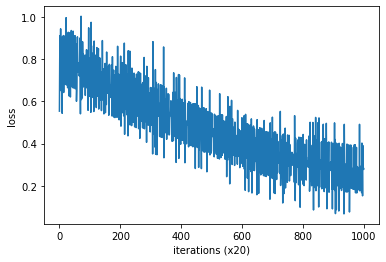

you [-0.98670006  1.309812   -1.4366899   2.1197653   2.8154325 ]
say [ 1.0509644 -1.1008953  1.5455601 -1.6172589 -1.7177469]
goodbye [-1.7329228   1.4185125  -1.2609001   0.17266847 -0.5458834 ]
and [ 2.8060546  -2.814669   -0.32006273  0.3617027  -1.2748733 ]
i [-1.6958103   1.3984735  -1.2315435   0.15219872 -0.54839814]
hello [-0.98891854  1.3142812  -1.4391792   2.1197648   2.828082  ]
. [-1.3724561  1.3765504  2.4591548 -2.485014  -1.7620848]


In [19]:
skip_gram_trainer.plot()
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])